# Electrocardiogaphy (EKG) signal processing

In this Jupyter notebook we will be analyzing EKG data previously acquired with 12-lead electrocardiogram at Chapman University and Shaoxing People's Hospital. The provided trial is part of a database containing 10,646 patients. Data were acquired consist of:
- Data duration: 10-seg segments
- Sampling rate: 500 Hz
- Units: EKG units are in 𝜇𝑉. 

The selected subject is an 18-year-old male. The complete dataset can be accessed [here](https://figshare.com/collections/ChapmanECG/4560497/2).

## Data analysis workflow
After the data has been acquired, it can be processed using specialized software. This software might be from the same manufacturer as the recording instrument. These software will often allow the data to be exported as a comma-separated value (i.e., `.CSV`) file type. Some manufacturers will also provide tools that allow for real-time access to the data while recording. 

## Import libraries
First, we will import the necessary libraries to read and analyze the downloaded [EKG data](./ekg_data.csv).

In [1]:
## Import libraries
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, detrend, iirnotch, find_peaks, filtfilt

## Import EKG data
First, we will import the EKG data from the [ekg_data.csv](ekg_data.csv) file with the `pandas` module.

In [2]:
# Settings
file_name = 'ekg_data.csv'
srate = 500 # Sampling rate [Hz]

# Import data and visualize 5 first rows
raw_data = pd.read_csv(file_name)
print(raw_data.head())


       I      II    III     aVR    aVL    aVF     V1      V2      V3      V4  \
0 -53.68 -112.24 -58.56   82.96   0.00 -87.84  -9.76 -102.48 -200.08 -224.48   
1   9.99  -33.93  24.63  151.51  58.79  -4.65  63.67  -38.81 -141.29 -165.69   
2  41.44   -2.48  56.08  182.96  90.24  26.80  90.24  -17.12 -119.60 -148.88   
3  13.91  -25.13  38.31  160.31  62.71   4.15  67.59  -44.65 -147.13 -166.65   
4 -50.51  -74.91 -11.47   91.01  -6.59 -45.63   3.17 -109.07 -206.67 -231.07   

       V5      V6  
0 -141.52 -102.48  
1  -82.73  -48.57  
2  -51.28  -26.88  
3  -83.69  -49.53  
4 -138.35 -104.19  


## Visualize raw EKG
For this example we will be only using the the **Lead II** derivation since this is the most commonly used in clinical settings due to its aligment with the heart's electrical axis. Next, we will plot the raw data

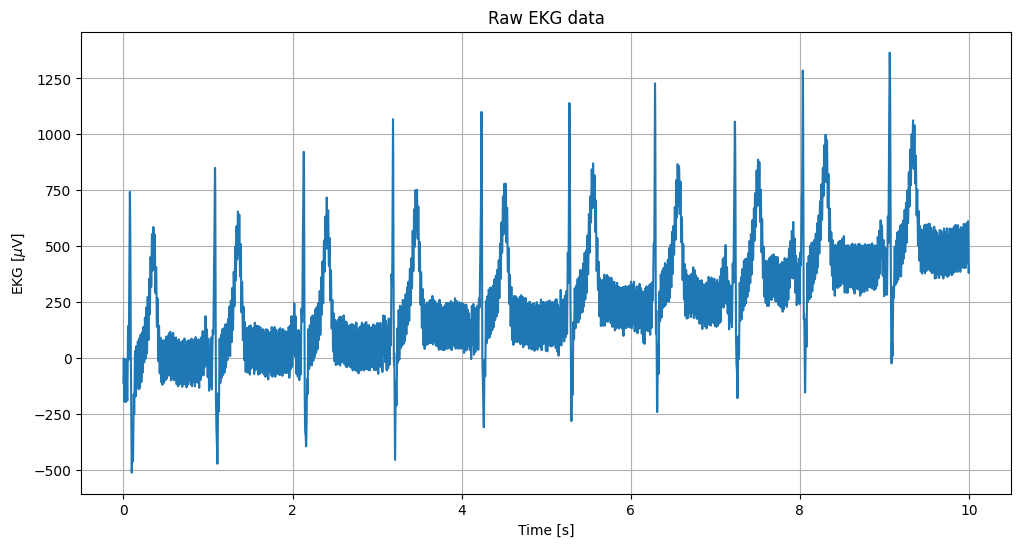

In [3]:
# Settings
time_mask = False    # Boolean to trim time for plot
time_start = 0      # Start time [s]
time_end = 2        # End time [s]

# Extract data
lead2_raw = raw_data['II'].to_numpy()               # Lead II data vector [uV]
time = np.arange(0, len(lead2_raw)/srate, 1/srate)  # Time vector [sec]

# Mask data for plotting 
if time_mask:
    time_mask_vector = (time >= time_start) & (time <= time_end)
    time = time[time_mask_vector]
    lead2_raw = lead2_raw[time_mask_vector]
else:
    time_plot = time
    ekg_plot = lead2_raw

# Plot raw data
plt.figure(figsize=(12, 6))
plt.plot(time, lead2_raw)
plt.xlabel('Time [s]')
plt.ylabel('EKG [$\mu$V]')
plt.title('Raw EKG data')
plt.grid()

## Frequency spectrum
First, we will compute the signal Fast Fourier Transform. This will reveal additional information about the possible noise sources that are affecting the signal.
Note that the majority of the EKG power is located between 0 and 40 Hz. 

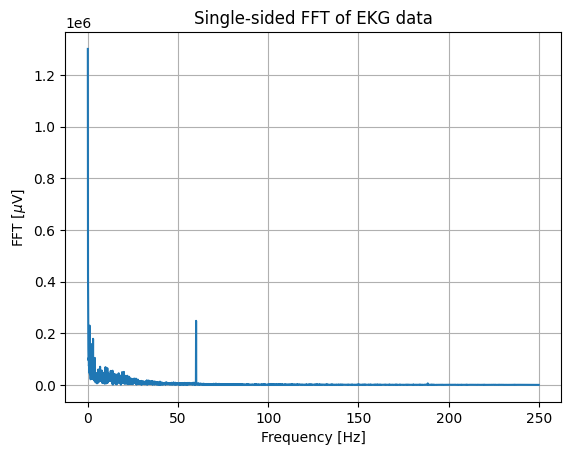

In [9]:
# Calculate the FFT
fft_result = np.fft.fft(lead2_raw)
fft_freq = np.fft.fftfreq(len(lead2_raw), d=1/srate)

# Take the single-sided FFT
single_sided_fft = np.abs(fft_result[:len(fft_result)//2])
single_sided_freq = fft_freq[:len(fft_freq)//2]

# Plot the single-sided FFT
plt.figure()
plt.plot(single_sided_freq, single_sided_fft)
plt.xlabel('Frequency [Hz]')
plt.ylabel('FFT [$\mu$V]')
plt.title('Single-sided FFT of EKG data')
plt.grid()

## Filtering

### Notch-filtering
As you can see in the raw data plot, the signal is contaminated with some power-line noise. Design and apply a zero-phase FIR filter to eliminate this noise. Plot the power spectrum before and after the noise, as well as the time series to see the results.

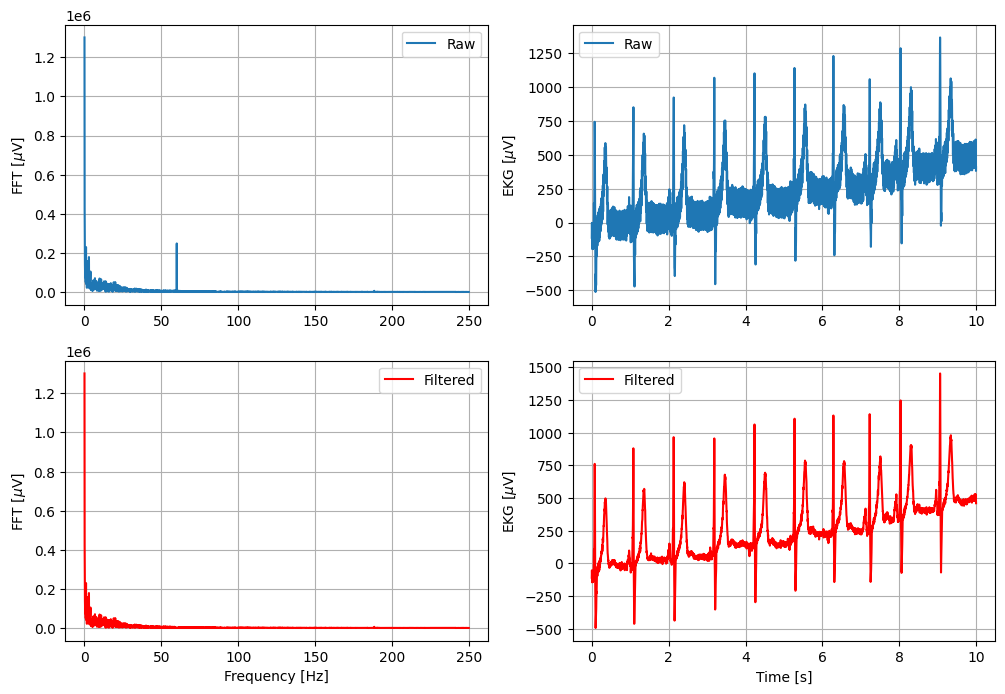

In [10]:
# Design zero-phase notch FIR filter
# -- Filter settings
f0 = 60  # Notch frequency [Hz]
Q = 30    # Quality factor (higher Q = narrower notch)

# Design elliptic notch filter
nyq = srate/2   # Nyquist frequency [Hz]
w0 = f0/nyq     # Normalized notch frequency [0, 1]
bw = f0/Q/nyq   # Normalized notch bandwidth [0, 1]
order = 4       # Filter order

# Create the notch filter
b, a = iirnotch(w0, Q)

# Apply filter forward and backward for zero phase
lead2_notch = filtfilt(b, a, lead2_raw)

# Plot raw and filtered FFTs and time series
# -- Calculate the FFT of the filtered signal
fft_result_filtered = np.fft.fft(lead2_notch)
single_sided_fft_filtered = np.abs(fft_result_filtered[:len(fft_result_filtered)//2])

# -- Plot the raw and filtered FFTs
[fig, ax] = plt.subplots(2,2, figsize=(12,8))

ax[0,0].plot(single_sided_freq, single_sided_fft)
ax[0,0].set_ylabel('FFT [$\mu$V]')
ax[0,0].legend(['Raw'])
ax[0,0].grid()

ax[1,0].plot(single_sided_freq, single_sided_fft_filtered, color='r')
ax[1,0].set_xlabel('Frequency [Hz]')
ax[1,0].set_ylabel('FFT [$\mu$V]')
ax[1,0].legend(['Filtered'])
ax[1,0].grid()

# -- Plot the raw and filtered time series
ax[0,1].plot(time_plot, ekg_plot)
ax[0,1].set_ylabel('EKG [$\mu$V]')
ax[0,1].legend(['Raw'])
ax[0,1].grid()

ax[1,1].plot(time_plot, lead2_notch, color='r')
ax[1,1].set_xlabel('Time [s]')
ax[1,1].set_ylabel('EKG [$\mu$V]')
ax[1,1].legend(['Filtered'])
ax[1,1].grid()

plt.show()

### Detrending the data
Note that the power line noise is not visible in the data any more. However, it still seems that the data has a drift to it (i.e., a very low frequency component that shifts the signal up or down). Now we will apply a detrend to remove this artifact.

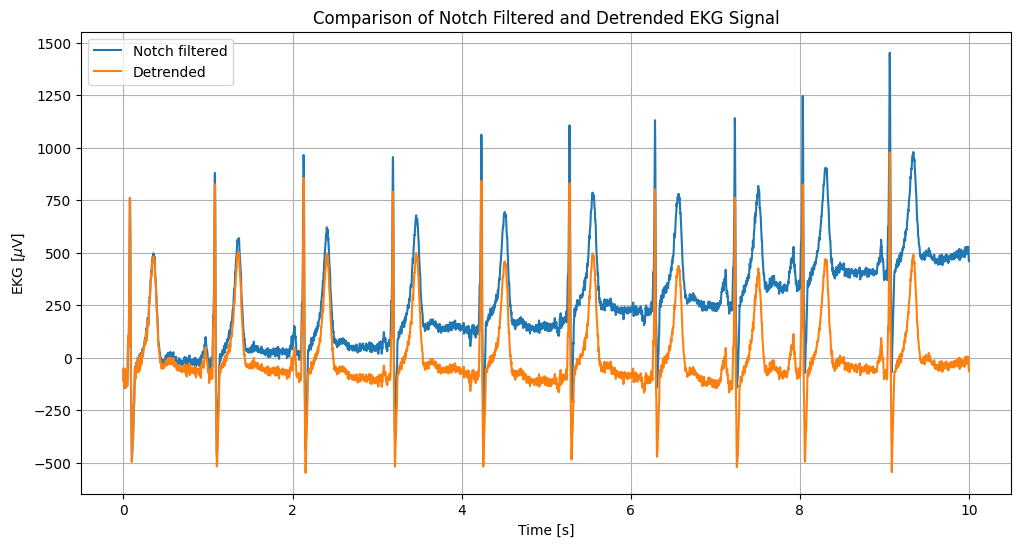

In [6]:
# Detrend the notch-filtered signal using scipy
lead2_detrend = detrend(lead2_notch)

# Plot notch-filtered and detrended signals
plt.figure(figsize=(12, 6))
plt.plot(time_plot, lead2_notch, label='Notch filtered')
plt.plot(time_plot, lead2_detrend, label='Detrended')
plt.xlabel('Time [s]')
plt.ylabel('EKG [$\mu$V]')
plt.title('Comparison of Notch Filtered and Detrended EKG Signal')
plt.legend()
plt.grid(True)
plt.show()

## Heart beat computation

### Finding R peaks

First, we'll find the peaks above $mean + (n*SD)$, where we will set the appropriate `n` value for this dataset.

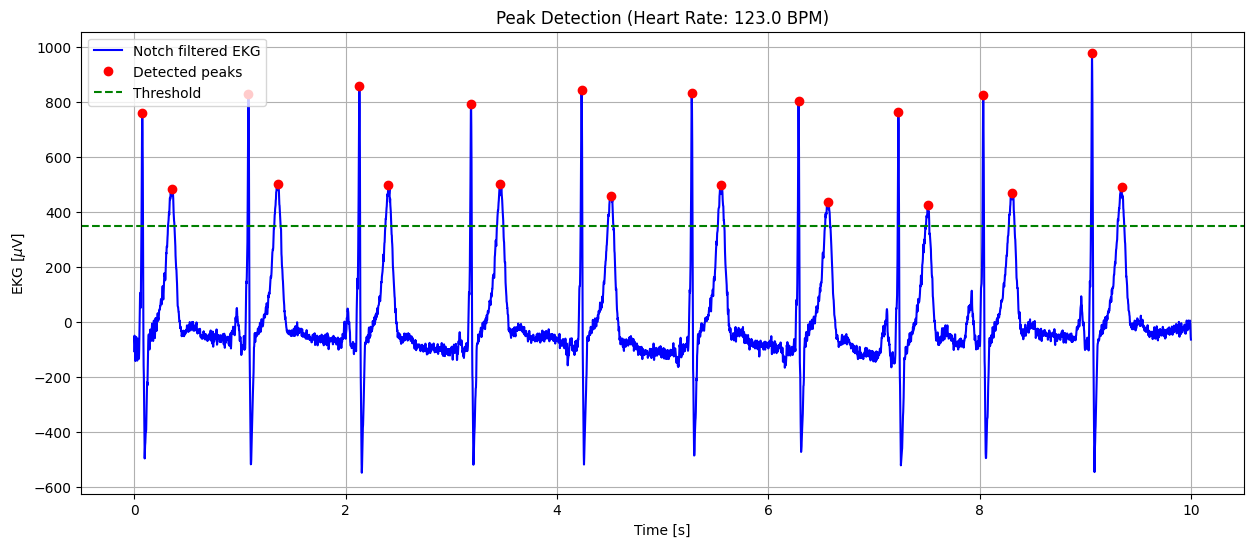

In [7]:
# Find peaks using a threshold method
sd_multiplier = 2  # Multiplier for the standard deviation threshold
threshold = np.mean(lead2_detrend) + sd_multiplier * np.std(lead2_detrend)  # Set threshold at mean + multiplier * SD
peaks = []
min_distance = int(0.2 * srate)  # Minimum 200ms between peaks

# Find peaks using scipy's find_peaks function
peaks, _ = find_peaks(lead2_detrend, height=threshold, distance=min_distance)

# Calculate heart rate
peak_intervals = np.diff(peaks) / srate  # Convert to seconds
hr = 60 / np.mean(peak_intervals)  # Convert to beats per minute

# Plot the signal with detected peaks
plt.figure(figsize=(15, 6))
plt.plot(time, lead2_detrend, 'b-', label='Notch filtered EKG')
plt.plot(time[peaks], lead2_detrend[peaks], 'ro', label='Detected peaks')
plt.axhline(y=threshold, color='g', linestyle='--', label='Threshold')
plt.xlabel('Time [s]')
plt.ylabel('EKG [$\mu$V]')
plt.title(f'Peak Detection (Heart Rate: {hr:.1f} BPM)')
plt.legend()
plt.grid(True)
plt.show()

### Using Pan Tompkings algorithm

Since the required `n` value can depend on the amplitude of other components of the EKG signal (e.g., P-waves), more complex methods are commonly used. For example the Pan Tompkings algorithm. This method is fully described [here](https://ieeexplore.ieee.org/document/4122029).

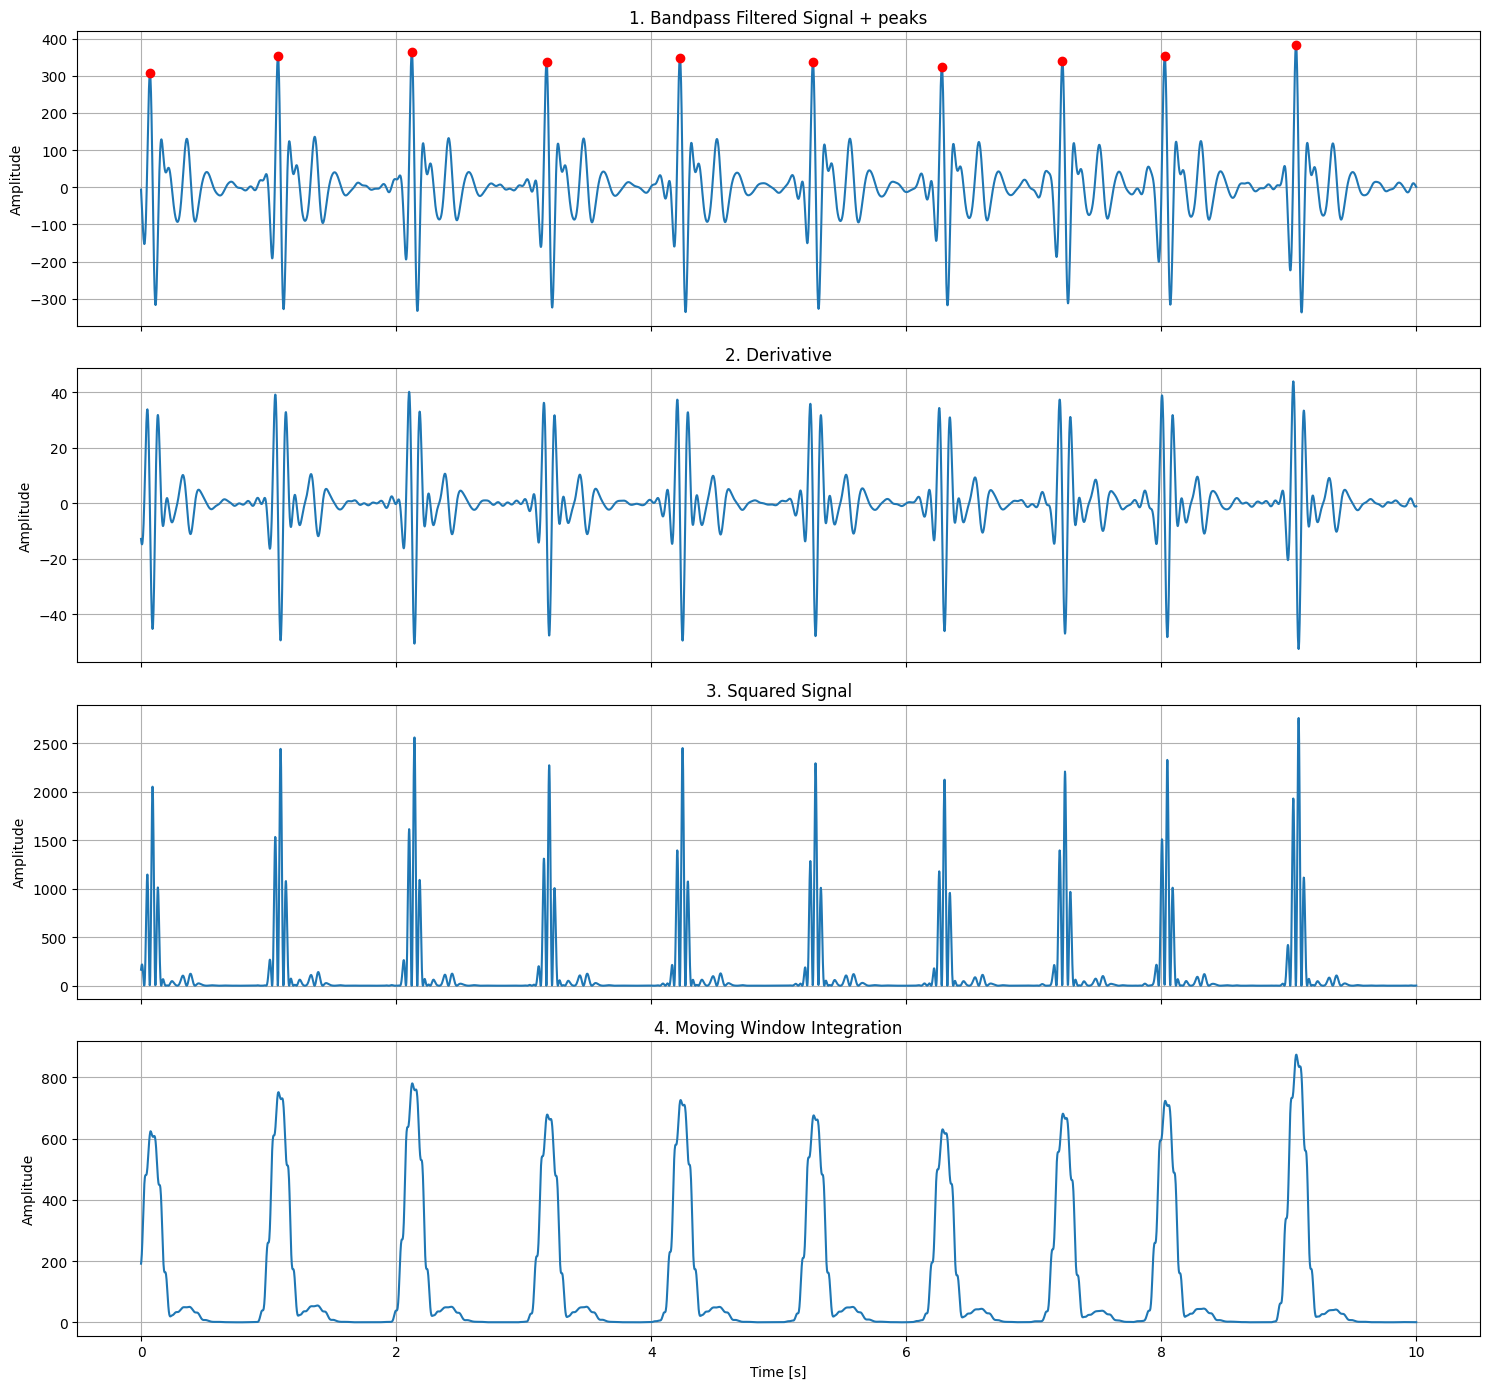

In [8]:
# Helper functions
def pan_tompkins(raw_signal: np.ndarray, srate: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    '''
    Pan-Tompkins algorithm for QRS detection
    
    Parameters
    ----------
    raw_signal : array
        The raw EKG signal
    srate : float
        The sampling frequency of the EKG signal
    
    Returns
    -------
    filtered : array
        The bandpass filtered signal
    derivative : array
        The derivative of the filtered signal
    squared : array
        The squared values of the derivative
    moving_average : array
        The moving average of the squared values
    '''

    # 1. Apply band-pass filter to signal
    order = 6
    fc = [5, 15]
    sos = butter(4, fc, 'band', fs=srate, output='sos')
    filtered = sosfiltfilt(sos, raw_signal)
    
    # 2. Derivative
    derivative = np.diff(filtered)
    derivative = np.append(derivative, derivative[-1])
    
    # 3. Squaring
    squared = derivative ** 2
    
    # 4. Moving average integration
    window_size = int(0.15 * srate)  # 150ms window
    moving_average = np.convolve(squared, np.ones(window_size)/window_size, mode='same')

    # Adaptive thresholding
    peaks = peak_detection(filtered, moving_average, srate)
    # peaks = adaptive_thresholding(moving_average, srate, refractory=0.2)
    
    return filtered, derivative, squared, moving_average, peaks

def peak_detection(filtered_signal: np.ndarray, moving_average: np.ndarray, srate: float) -> np.ndarray:
    """
    Simple peak detection algorithm

    Parameters
    ----------
    filtered_signal : array
        The filtered EKG signal
    moving_average : array
        The moving average of the squared values
    srate : float
        The sampling frequency of the EKG signal in Hz
    
    Returns
    -------
    peaks : array
        The indices of the detected peaks
    """
    
    window_size = int(0.15 * srate)  # 150ms
    min_distance = int(0.2 * srate)  # Minimum 200ms between peaks
    peak_threshold = 0.3 * np.max(moving_average)
    
    peaks = []
    i = window_size
    while i < len(moving_average) - window_size:
        if moving_average[i] > peak_threshold:
            # Find local maximum in filtered signal
            window_start = max(0, i - window_size)
            window_end = min(len(filtered_signal), i + window_size)
            local_max_idx = window_start + np.argmax(filtered_signal[window_start:window_end])
            
            if not peaks or (local_max_idx - peaks[-1]) > min_distance:
                peaks.append(local_max_idx)
                i = local_max_idx + min_distance
            else:
                i += 1
        else:
            i += 1

    return peaks

# Find peaks with Pan Tompkins algorithm
filtered, derivative, squared, moving_average, peaks = pan_tompkins(lead2_raw, srate)

# Plot all stages
fig, axs = plt.subplots(4, 1, figsize=(15, 14), sharex=True)

# Filtered signal + peaks
axs[0].plot(time, filtered)
axs[0].plot(time[peaks], filtered[peaks], 'ro')
axs[0].set_title('1. Bandpass Filtered Signal + peaks')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

# Derivative
axs[1].plot(time, derivative)
axs[1].set_title('2. Derivative')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)

# Squared
axs[2].plot(time, squared)
axs[2].set_title('3. Squared Signal')
axs[2].set_ylabel('Amplitude')
axs[2].grid(True)

# Moving average
axs[3].plot(time, moving_average)
axs[3].set_title('4. Moving Window Integration')
axs[3].set_xlabel('Time [s]')
axs[3].set_ylabel('Amplitude')
axs[3].grid(True)

plt.tight_layout()
plt.show()

## Additional testing

In this folder there are two more trials:
- [ekg_st](ekg_st.csv). This trial contains an example of Sinus tachycardia.
- [ekg_sb_aqw](ekg_sb_aqw.csv). This trial contains an example of Sinua bradychardia with abnormal Q wave

Run your own signal processing techniques and think about the best strategy to extract useful features from these files.